In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import json

In [2]:
def group_flattened_experiment_results(results):
    df = pd.DataFrame(results)
    grp = df.groupby(['al_algorithm','trained_samples']).agg(['mean', 'median', 'var']).reset_index()
    grp.columns = [first if second == '' else first + '_' + second for first, second in grp.columns.values]
    return grp

In [3]:
def print_plot(results, title="Experiments"):
#     results = results.sort_values('al_algorithm', ascending=False)
    fig, ax =plt.subplots(figsize=(15,10))
    
    sns.lineplot(data=results, hue='al_algorithm', style='al_algorithm', x = "trained_samples",  y = "_f1", ci='sd',  ax = ax,
                 marker='o', 
                  palette=['goldenrod', 'indigo', 'darkgreen']
                )
#     ax.lines[0].set_linestyle("dotted")
#     ax.lines[2].set_linestyle("dotted")
    ax.legend( title = "F1-Score " + title)
    fig.show()

In [4]:
pd.read_json('results/full_runtimes.json', orient='records').drop(columns=['duration']).to_json('results/full_runtimes_new.json', orient='split')

In [5]:
def load_result(src:str):
    from datetime import datetime, timedelta
    res = []
    data = pd.read_json('results/full_runtimes.json').drop(columns=['duration'])
    for a in data.columns:
        for rand_id, rand_row in enumerate(data[a]):
            for fold_id in range(len(rand_row)):
                l = len(rand_row[fold_id][list(rand_row[fold_id])[0]])
                res_row = [{c : None for c in rand_row[fold_id] } for i in range(l)]

                for col in rand_row[fold_id]:
                     i = 0
                     for k in rand_row[fold_id][col]:
                         if col.startswith('duration'):
                             res_row[i][col] = timedelta(milliseconds=rand_row[fold_id][col][k])
#                              res_row[i][col+'_timestamp'] = rand_row[fold_id][col][k]
                             res_row[i][col+'_seconds'] = res_row[i][col].total_seconds()
#                              res_row[i][col+'_milliseconds'] = res_row[i][col].total_seconds()*1000
                         else:
                             res_row[i][col] = rand_row[fold_id][col][k]

                         res_row[i]['fold_id'] = fold_id
                         res_row[i]['random_id'] = rand_id
                         res_row[i]['al_algorithm'] = a
                         i = i + 1
                for r in res_row:
                    res.append(r)
    return res


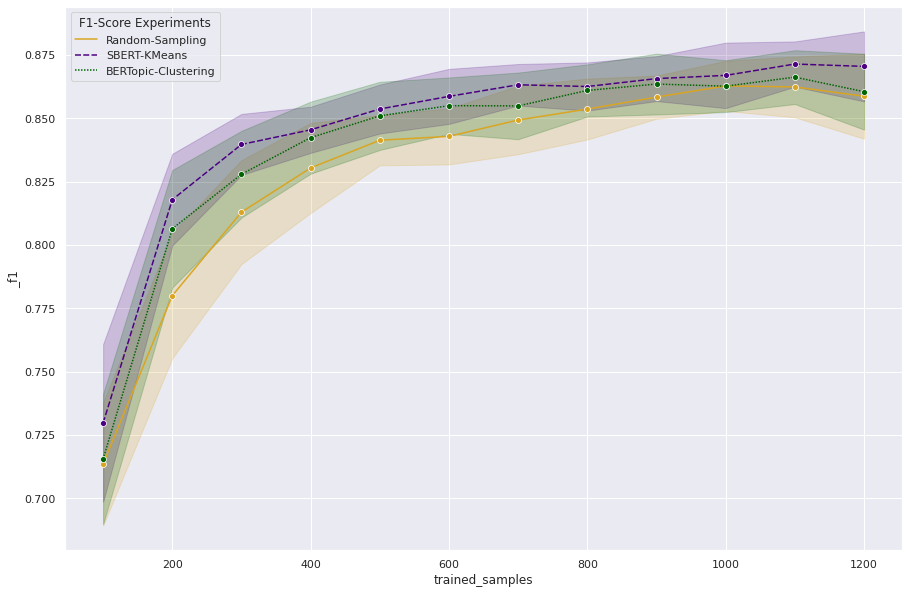

In [6]:
data = pd.DataFrame(load_result('results/full_runtimes_optimized.json'))

print_plot(data[data['trained_samples']<1300])

## Comparison Table

In [7]:
def get_pivot_from_data(data):
    sub = data[['al_algorithm', 'random_id', 'fold_id', 'trained_samples', '_f1']]
    sgrp = sub.groupby(['al_algorithm', 'trained_samples']).agg(['mean']).reset_index()
    sgrp.columns = [first if second == '' else first + '_' + second for first, second in sgrp.columns.values]
    sgrp = sgrp.drop(['random_id_mean', 'fold_id_mean'], axis=1)
    pvt = sgrp.pivot(index='trained_samples', columns='al_algorithm')

    # pvt.columns = pvt.columns.get_level_values(0)
    pvt.columns = ['_'.join([c.replace('_mean','').strip('_') for c in col]) for col in pvt.columns.values]
    pvt["Difference-SBERT-KMeans-to-RandomSampling"] = pvt['f1_SBERT-KMeans'] - pvt['f1_Random-Sampling']
    pvt["Difference-BERTopic-Clustering-Distance-to-RandomSampling"] = pvt['f1_BERTopic-Clustering'] - pvt['f1_Random-Sampling']
    pvt["Difference-SBERT-KMeans-to-BERTopic-Clustering"] = pvt['f1_SBERT-KMeans'] - pvt['f1_BERTopic-Clustering']
    cols = pvt.columns.tolist()
    cols = list([cols[1]]) + list([cols[2]]) +  list([cols[0]]) + cols[-3:]
    print(cols)
    pvt = pvt[cols]
    return pvt
def get_max_arg_by_column(col, data):
    arg = np.argmax(pvt[col])
    return arg, data.iloc[arg]

In [8]:
pvt = get_pivot_from_data(data)
pvt[pvt.index < 10000]

['f1_Random-Sampling', 'f1_SBERT-KMeans', 'f1_BERTopic-Clustering', 'Difference-SBERT-KMeans-to-RandomSampling', 'Difference-BERTopic-Clustering-Distance-to-RandomSampling', 'Difference-SBERT-KMeans-to-BERTopic-Clustering']


,f1_Random-Sampling,f1_SBERT-KMeans,f1_BERTopic-Clustering,Difference-SBERT-KMeans-to-RandomSampling,Difference-BERTopic-Clustering-Distance-to-RandomSampling,Difference-SBERT-KMeans-to-BERTopic-Clustering
trained_samples,,,,,,
100,0.713531,0.729688,0.715494,0.016157,0.001964,0.014194
200,0.779985,0.817873,0.806392,0.037888,0.026407,0.011481
300,0.812954,0.839670,0.827912,0.026716,0.014958,0.011758
400,0.830404,0.845456,0.842359,0.015052,0.011956,0.003096
500,0.841329,0.853659,0.850956,0.012331,0.009627,0.002703
600,0.842863,0.858647,0.854978,0.015784,0.012114,0.003670
700,0.849324,0.863231,0.854885,0.013907,0.005561,0.008346
800,0.853632,0.862539,0.860992,0.008908,0.007360,0.001548
900,0.858360,0.865668,0.863519,0.007308,0.005159,0.002149


#### Max BERTTopic Clustering Distance to Random Sampling

In [9]:
get_max_arg_by_column("Difference-BERTopic-Clustering-Distance-to-RandomSampling", pvt)

(1,
 f1_Random-Sampling                                           0.779985
 f1_SBERT-KMeans                                              0.817873
 f1_BERTopic-Clustering                                       0.806392
 Difference-SBERT-KMeans-to-RandomSampling                    0.037888
 Difference-BERTopic-Clustering-Distance-to-RandomSampling    0.026407
 Difference-SBERT-KMeans-to-BERTopic-Clustering               0.011481
 Name: 200, dtype: float64)

#### Max SBERT-KMeans Distance to Random Sampling

In [10]:
get_max_arg_by_column("Difference-SBERT-KMeans-to-RandomSampling", pvt)

(1,
 f1_Random-Sampling                                           0.779985
 f1_SBERT-KMeans                                              0.817873
 f1_BERTopic-Clustering                                       0.806392
 Difference-SBERT-KMeans-to-RandomSampling                    0.037888
 Difference-BERTopic-Clustering-Distance-to-RandomSampling    0.026407
 Difference-SBERT-KMeans-to-BERTopic-Clustering               0.011481
 Name: 200, dtype: float64)

#### Max SBERT-KMeans Distance to BERTTopic Clustering

In [11]:
get_max_arg_by_column("Difference-SBERT-KMeans-to-BERTopic-Clustering", pvt)

(0,
 f1_Random-Sampling                                           0.713531
 f1_SBERT-KMeans                                              0.729688
 f1_BERTopic-Clustering                                       0.715494
 Difference-SBERT-KMeans-to-RandomSampling                    0.016157
 Difference-BERTopic-Clustering-Distance-to-RandomSampling    0.001964
 Difference-SBERT-KMeans-to-BERTopic-Clustering               0.014194
 Name: 100, dtype: float64)

## Duration 

In [12]:
df = pd.DataFrame(data)
grp = df.groupby(['al_algorithm']).agg(['mean', 'std'], numeric_only=False).reset_index()
grp.columns = [first if second == '' else first + '_' + second for first, second in grp.columns.values]
grp = grp.sort_values('duration_total_seconds_mean', ascending=True).reset_index()
grp[['al_algorithm', 'duration_al_seconds_mean','duration_al_seconds_std', 'duration_ml_seconds_mean', 'duration_total_seconds_mean']]

,al_algorithm,duration_al_seconds_mean,duration_al_seconds_std,duration_ml_seconds_mean,duration_total_seconds_mean
0,Random-Sampling,0.000000,0.000000,29.501594,29.501842
1,BERTopic-Clustering,7.907694,3.641759,29.365767,37.274021
2,SBERT-KMeans,44.652347,18.385529,29.483392,74.136317
